#### This notebook is for analysing the results of the recognition task

In [31]:
import os, sys

import pymongo as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import math

import matplotlib
from matplotlib import pylab, mlab, pyplot
import matplotlib.patches as mpatches
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')
from matplotlib import rcParams

matplotlib.rcParams['pdf.fonttype'] = 42
# mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.cm as cm
import matplotlib.lines as mlines


from IPython.display import clear_output
import importlib

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
warnings.filterwarnings("ignore")


# so dataframes don't get cut off in display:
#pd.set_option("display.max_rows", None, "display.max_columns", None)

# a way to hide the little red error warnings that show up sometimes: (https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython)    
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')


### set up paths

In [2]:
# directory & file hierarchy
proj_dir = os.path.abspath('..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
datastructures_dir = os.path.join(analysis_dir,'datastructures')

## add helpers to python path
if os.path.join(proj_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'utils'))   

def make_dir_if_not_exists(dir_name):   
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    return dir_name

## create directories that don't already exist        
result = [make_dir_if_not_exists(x) for x in [results_dir,plot_dir,csv_dir,datastructures_dir]]

## add utils to python path
import sys
if os.path.join(proj_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'utils'))
import utils

### establish connection to mongo
first thing you need to do is to establish an ssh tunnel (aka remote port forwarding) to the server, so that requests to the mongodb can be made "as if" the mongodb server is running on your local computer. Run this from the command line before you begin data analysis if you plan to fetch data from mongo:

ssh -fNL 27020:127.0.0.1:27017 USER@cogtoolslab.org

In [3]:
! ssh -fNL 27020:127.0.0.1:27017 sholt@cogtoolslab.org

In [4]:
# set vars 
auth = pd.read_csv(os.path.join(analysis_dir,'auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org'

# have to fix this to be able to analyze from local
import pymongo as pm
import socket
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1:27017')
db = conn['iterated_number']
coll = db['num8_shape4_recognition']

# which iteration name should we look into?
iterationName = 'run1' 
# existing iterationNames: 'testing1', 'run1'

# db.list_collection_names()
# len(list(coll.find({'workerID':'XXXXXX'})))
          

In [5]:

## here is what one of these records looks like
# coll.find_one()
# There have been a total of 49 distinct workers, who produced 3729 total sketch ratings

total_ratings = len(list(coll.find({'iterationName':'run1'})))
distinct_workers = list(coll.find({'iterationName':'run1'}).distinct("workerID"))

print("There have been a total of {} distinct workers, who produced {} total sketch ratings".format(len(distinct_workers),total_ratings))    

for worker in distinct_workers:
    print(worker, list(coll.find({'workerID':worker}).distinct("recog_gameID")))


# save the list of distinct recognizers out to a datastructure
np.save(os.path.join(datastructures_dir,"recognizers_list.npy"),distinct_workers)


There have been a total of 218 distinct workers, who produced 17514 total sketch ratings
A1ROEDVMTO9Y3X ['8671-31c4b4e4-d97d-4c71-9bbf-1ec9d2bbe29e', '6483-d75e1308-7808-4e4f-aa19-7a06bd322264']
A2Y87M8V0N1M6P ['8882-6659df5b-d339-40ba-acde-dc38a1ad0d54', '6010-12423a2b-9525-457a-841d-01e00267b69b']
AW97F7PIA0U53 ['0608-d064aee3-da31-483a-81c5-ad2d9de9ea06', '5576-ae486fb7-4889-47ea-ab19-665917c4e505']
A2OPYRV3GLAPS1 ['9881-df27a6f0-8810-472f-872a-0a8973dd06aa', '8807-f70ae503-4a30-4c61-b66d-790d7e0c173c']
A2RCYLKY072XXO ['3864-c7f8daec-8598-4907-af43-97b4fbd81288']
AJRY9ALX8069Y ['2250-32fc294f-5936-4466-838f-a567037da5fc']
A1HWB810RJBV2K ['8883-f43ef9df-f280-4f1e-920d-69215e467e08']
A2Z6NL0CTXY0ZB ['0048-5ffed0df-cace-44b1-9853-b921e17103a7']
AY9UWGHEE2P04 ['0608-2ad1ac14-9fe0-497e-9fb8-da02889b1319', '5742-2e2a0d10-15a3-4306-9142-d43a57d6aca8', '7100-8b85e3c4-18de-49ae-935d-1ebf92eaf8db']
A20XDCBFKG4TEE ['1180-3d39cddc-4dab-4103-a16c-b4670d85d591']
A2MOKIEQZ0OF2M ['1025-30e4204b-773

A3LPHYONE222OY ['8050-374bf9c7-0c44-48c2-9944-1feab4e0e1d6']
A2UIGDOLX5RV95 ['5945-86291937-ba3a-4bed-93eb-7074e9347bbd']
AQAXDL1INQC9Q ['2321-db6c97a3-2a35-4af3-94f2-5bd88bb45c16']
A3RYI5HXC2MJLN ['4053-030e32fc-8345-4250-8d81-ce5e8465ae77', '1290-eb3248b3-6f8b-41c8-b44f-4e38b72659d4']
A3POD149IG0DIW ['1808-ee9cfa08-6ef4-473c-87b9-14db822aa3ff']
A3FOKP72T5I4FR ['6036-19119103-ba30-40a5-bb79-3d9946238242']
A64JDJKE9DYCT ['2234-81f3c641-8127-4bec-a628-5a3b1d369fc2']
A1O57XVTTB1PNZ ['2210-cd2e7535-0d18-49f4-9c23-2e0b0d725d9e']
A3MX0NRVZLF8C ['0830-77fdc423-77b8-4df6-b348-320fce76c29b', '4270-f865da24-7f53-4aa3-bca3-08248378adf4']
A5NE8TWS8ZV7B ['3638-cee9dcff-aee8-4cc0-9564-c301bc420b6a']
A3UV55HC87DO9C ['4045-3c387fa3-fe1d-4771-9ce9-c74e450ef940']
AKSJ3C5O3V9RB ['4513-159de7fa-e640-489f-9783-2d085b63e4ac', '4888-d764480a-26ca-408f-a653-363aa247b7c6']
A2I2E366RTBJED ['8085-fb0726cc-c797-4c3c-8620-d324e99e0cf8', '0503-a9b5ab5d-83c2-4302-a2dd-ee16f5f84102']
A2FOUSWQDYHIE0 ['8403-99b9efe9-6

In [6]:
## fetch records that match our list of iterationNames
print('Currently trying to generate  dataframe...')
r = coll.find({'iterationName': iterationName})
## create (raw, unfiltered) dataframe 
## data from iterationNames of interest
R = pd.DataFrame(list(r))
print('Finished generating dataframe.')

## get list of valid game IDs (i.e, subject number)
from collections import Counter
game_dict = Counter(R['recog_gameID']) ## get dictionary mapping gameIDs to number of sketches 
complete_gameids = [r for (r,v) in game_dict.items() if v==65] ## get gameids that contributed exactly the right number of sketches

## subset stroke/sketch dataframes by being complete
subset = True
if (subset and R['recog_gameID'].nunique()!=len(complete_gameids)):
    R = R[(R['recog_gameID'].isin(complete_gameids))].reset_index(drop=True)
    
print('We have {} unique sketch records in all {} of our complete games.'.format(R.shape[0],len(complete_gameids)))

# save out to csv
R.to_csv(os.path.join(csv_dir,'iternum_recog_data.csv'),index=False)
print('Successfully saved out our recog data CSV to {}.'.format(csv_dir))

print()
for i in game_dict.keys():
    if game_dict[i] < 65:
        print(i, game_dict[i])

# We have 3510 unique sketch records in all 54 of our complete games.


Currently trying to generate  dataframe...
Finished generating dataframe.
We have 17160 unique sketch records in all 264 of our complete games.
Successfully saved out our recog data CSV to /Users/alles/repos/iterated_number/results/csv.

8882-6659df5b-d339-40ba-acde-dc38a1ad0d54 33
3864-c7f8daec-8598-4907-af43-97b4fbd81288 6
7641-eeb2cb6f-a366-4068-bc50-baa77cda4844 33
5185-3f9a8715-fade-4b5e-aa95-d2a2cedfc806 8
9382-637df577-6cd4-4f4c-b0ae-ac69e25e0bba 9
2831-9d232e98-2957-4e95-ae39-08a93f2024eb 11
0212-17fef2eb-f218-453d-a04d-24ddac03af85 19
5129-2035d37a-9f87-4db4-ac9e-17978c4566ed 5
7934-6f687225-63a9-4eb0-b3c1-133749dcc181 19
0888-0f447436-7020-436c-b061-06878c8ba8c7 18
4053-030e32fc-8345-4250-8d81-ce5e8465ae77 15
7111-62e50de2-ab64-474a-a1a7-f5b15674247e 4
8298-0c9069e0-314d-44c8-9dc4-b4ef44b8193c 39
1158-3e4a1bc4-7160-4d1d-ace5-1aab241dc85c 10
1553-e377eb44-bea9-44b6-a49c-07de0a013732 8
6470-22dc7eab-3ce6-4abf-809e-5bcf9d1c42b3 15
2233-045a1cac-af4c-4f84-891d-f786c588f53e 22
736

### Cleaning the data

In [7]:

# Turning things that can always be numeric into numeric things
R = R.astype({'orig_sketch_cardinality': 'float',
              'rating_trial_num': 'float'})

# add a new column for whether recognizer got the answer right
R['correct'] = np.nan

# now populate that column with correctness vals. We have to look at different columns for each rating condition
for r_num in range(len(R['rating'])):
    if R['rate_condition'][r_num] == 'number':
        R['rating'][r_num] = float(R['rating'][r_num])
        R['correct'][r_num] = R['rating'][r_num] == R['orig_sketch_cardinality'][r_num]
    elif R['rate_condition'][r_num] == 'shape':
        R['correct'][r_num] = R['rating'][r_num] == R['orig_sketch_animal'][r_num]
            
R = R.astype({'correct': 'float'})

print("Total of {} unique workers participated".format(len(R.workerID.unique())))
      

Total of 211 unique workers participated


### Who passed the 4 catch trials? Only look at them

In [8]:
# make a dataframe showing each recognizer's catch trial accuracy
catches = R[R['catch_trial'] == True]
catch_acc = pd.DataFrame(catches.groupby(['recog_gameID','workerID'])['correct'].mean())
catch_acc = catch_acc.rename(columns={"correct": "catch_accuracy"})
num_games = len(catch_acc)


# now get a list of the gameIDs who got perfect score on catch trials and filter everyone else out of the big DF
kosher_games = list(catch_acc[catch_acc['catch_accuracy'] == 1.0].reset_index()['recog_gameID'])
boolean_series = R.recog_gameID.isin(kosher_games) # get the indices of games that pass
D = R[boolean_series] # now filter R by those games, and call it D
D = D[D['catch_trial'] == False] # now remove all catch trials from D, as we don't need to analyse them
num_kosher_games = len(kosher_games)

# catch_acc # here's that dataframe

print("{} recog games passed, out of {} total.".format(num_kosher_games,num_games))
print("{} total unique workers passed this stage".format(len(D.workerID.unique())))
# The following line is for analyze_survey.ipynb so we can get all the worker IDs that are valid
# (forgot to save game_id to MTurk, but worker_id is also unique to game):
# print(list(catch_acc[catch_acc['catch_accuracy'] == 1.0].reset_index()['workerID']))


232 recog games passed, out of 264 total.
198 total unique workers passed this stage


### Now also exclude any workers who participated in the original task (for some reason, store.js wasn't doing this)

In [9]:
# get all the workers who participated in the production task
workerList = np.load("datastructures/workers_list.npy")
boolean_series = D.workerID.isin(workerList)
D = D[~boolean_series]
num_naive = len(D.workerID.unique())
num_games_naive = len(D.recog_gameID.unique())

print("{} recog participants not repeated from production.".format(num_naive))
print("{} recog games not from repeaters, out of {} total.".format(num_games_naive,num_kosher_games))
print("{} total unique workers passed this stage".format(len(D.workerID.unique())))


# save this list of distinct recognizers out to a datastructure
np.save(os.path.join(datastructures_dir,"valid_recognizers_list.npy"),D.workerID.unique())

# now save out the whole dataframe so we can run analyses in R:
D.to_csv(os.path.join(datastructures_dir,"recogData.csv"))


189 recog participants not repeated from production.
220 recog games not from repeaters, out of 232 total.
189 total unique workers passed this stage


### Now count how many times each sketch has been rated by a valid, naïve recognizer

In [10]:

# test = pd.DataFrame(D.groupby(['orig_game_id','orig_sketch_animal','orig_sketch_cardinality','rate_condition'])['orig_game_trial_num'].agg(['count'])).reset_index()            
# gameIDs = pd.unique(test['orig_game_id'])

# for game in gameIDs:
#     plt.figure(figsize=(4,16))
#     test[test['orig_game_id'] == game][test['rate_condition'] == 'shape'].reset_index().sort_values(by='count').plot.bar(y='count',x='index')#['count'].min()
#     plt.xlabel('Stimulus Partition')
#     plt.ylabel('# of Recog Games (shape)')
    
#     plt.figure(figsize=(4,16))
#     test[test['orig_game_id'] == game][test['rate_condition'] == 'number'].reset_index().sort_values(by='count').plot.bar(y='count',x='index')#['count'].min()
#     plt.xlabel('Stimulus Partition')
#     plt.ylabel('# of Recog Games (number)')

# test[test['orig_game_id'] == '0074-988d4ee1-5766-47b5-bcbb-49a720aee30d']


In [11]:
valid_game_ids = np.unique(D[['recog_gameID']])

# save the list of valid gameIDs out to a datastructure so we can do the patch for getting missed recogs
np.save(os.path.join(datastructures_dir,"valid_game_ids.npy"),valid_game_ids)

In [12]:

counting = pd.DataFrame(D.groupby(['orig_game_id','orig_game_trial_num','rate_condition'])['orig_game_trial_num'].agg(['count'])).reset_index()    
# D.columns
counting['count']


0       4
1       4
2       3
3       4
4       3
       ..
3899    3
3900    4
3901    4
3902    4
3903    4
Name: count, Length: 3904, dtype: int64

### General accuracy measures

[Text(0, 0, '# Game'),
 Text(1, 0, 'Shape Game'),
 Text(2, 0, '# Game'),
 Text(3, 0, 'Shape Game')]

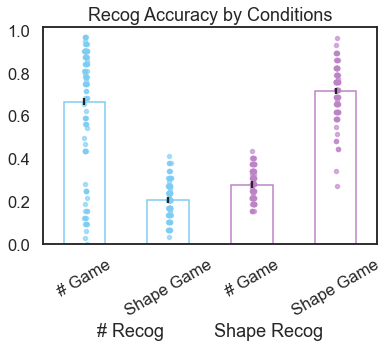

In [13]:
# get mean accuracty for each

def get_confint(df):
    """Takes a df already with columns ['Factors','Mean','Count','STD'] """
    new_df = df
    ci95_hi = []
    ci95_lo = []
    for i in new_df.index:
        m, c, s = new_df.loc[i]
        ci95_hi.append(m + 1.96*s/math.sqrt(c))
        ci95_lo.append(m - 1.96*s/math.sqrt(c))
    new_df['ci95_hi'] = ci95_hi
    new_df['ci95_lo'] = ci95_lo
    return new_df

condition_acc = get_confint(pd.DataFrame(D.groupby(['rate_condition','orig_game_condition'])['correct'].agg(['mean', 'count', 'std']))).reset_index()        
recognizer_acc = D.groupby(['rate_condition','orig_game_condition','workerID'])['correct'].mean().reset_index()    
CC_recognizer_acc = np.array(recognizer_acc[(recognizer_acc['orig_game_condition'] == 'number') & (recognizer_acc['rate_condition'] == 'number')]['correct'])        
AC_recognizer_acc = np.array(recognizer_acc[(recognizer_acc['orig_game_condition'] == 'shape') & (recognizer_acc['rate_condition'] == 'number')]['correct'])        
CA_recognizer_acc = np.array(recognizer_acc[(recognizer_acc['orig_game_condition'] == 'number') & (recognizer_acc['rate_condition'] == 'shape')]['correct'])        
AA_recognizer_acc = np.array(recognizer_acc[(recognizer_acc['orig_game_condition'] == 'shape') & (recognizer_acc['rate_condition'] == 'shape')]['correct'])        


# condition_acc # here's that dataframe


ax1 = condition_acc.plot.bar(y='mean',
                             yerr=condition_acc['ci95_hi'] - condition_acc['mean'],
                             rot=30,
                             legend=False) # here's a plot
ax1.set_title("Recog Accuracy by Conditions")
ax1.get_children()[1].set_color((0,0,0,0))
ax1.get_children()[2].set_color((0,0,0,0))
ax1.get_children()[3].set_color((0,0,0,0))
ax1.get_children()[4].set_color((0,0,0,0))

ax1.get_children()[1].set_edgecolor('#7DCCF4')
ax1.get_children()[2].set_edgecolor('#7DCCF4')
ax1.get_children()[3].set_edgecolor('#BD83C7')
ax1.get_children()[4].set_edgecolor('#BD83C7')

ax1.scatter(0 + np.random.random(CC_recognizer_acc.size) * .03, CC_recognizer_acc, color='#7DCCF4',s=16,alpha=.6)
ax1.scatter(1 + np.random.random(AC_recognizer_acc.size) * .03, AC_recognizer_acc, color='#7DCCF4',s=16,alpha=.6)

ax1.scatter(2 + np.random.random(CA_recognizer_acc.size) * .03, CA_recognizer_acc, color='#BD83C7',s=16,alpha=.6)
ax1.scatter(3 + np.random.random(AA_recognizer_acc.size) * .03, AA_recognizer_acc, color='#BD83C7',s=16,alpha=.6)

ax1.set_xlabel("# Recog          Shape Recog")
ax1.set_xticklabels(['# Game','Shape Game','# Game','Shape Game'])
# condition_acc.reset_index().columns
# ax1.__dict__['_axes']


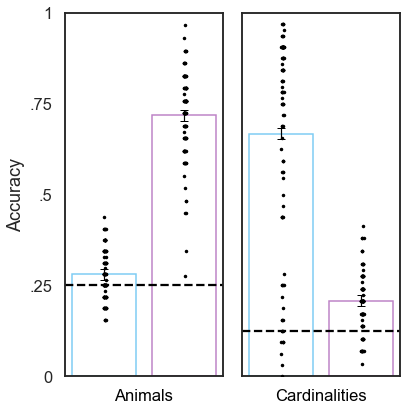

In [59]:
condition_acc#['mean'].mean()

# fig , (ax1,ax2) = plt.subplots(1,2 , figsize = (4,3.75))         # version 2
fig , (ax1,ax2) = plt.subplots(1,2 , sharey=True, figsize = (6,6)) # version 1

ax1.set_ylim(0,1)
ax2.set_ylim(0,1)

# fig.suptitle("Human", fontsize=24)                                 # version 1

shape_acc = condition_acc[condition_acc['rate_condition'] == 'shape']
ax1.bar(shape_acc['orig_game_condition'],
        height=shape_acc['mean'],
        color = ['#7DCCF4','#BD83C7'], alpha=1,
        yerr= shape_acc['ci95_hi']-shape_acc['mean'],
        error_kw={'linewidth':1.2,'capsize':4})


# ax1.set_xlabel("Animals",color='#A04EAE')
# ax1.set_xticklabels([])
ax1.set_yticks([])
ax1.set_yticklabels([])
ax1.set_xticks([.5])
ax1.set_xticklabels(["Animals"],color='k')
ax1.set_ylabel("Accuracy")
ax1.set_yticks([0,.25,.5,.75,1])
ax1.set_yticklabels(['0','.25','.5','.75','1'])


number_acc = condition_acc[condition_acc['rate_condition'] == 'number']
ax2.bar(number_acc['orig_game_condition'],
        height=number_acc['mean'],
        color = ['#7DCCF4','#BD83C7'], alpha=1,
        yerr= number_acc['ci95_hi']-number_acc['mean'],
        error_kw={'linewidth':1.2,'capsize':4})


# ax2.set_xlabel("Cardinalities",color='#6369AF')
ax2.set_xticks([.5])
ax2.set_xticklabels(["Cardinalities"],color='k')

l1=ax1.axhline(0.25,color='black',ls='--')
l1.set_label('l1')

l2=ax2.axhline(0.125,color='black',ls='--')
l2.set_label('l2')

# ax2.set_yticks([0,.25,.5,.75,1])
# ax2.set_yticklabels(['0','.25','.5','.75','1'])
# ax2.yaxis.tick_right()
# ax2.yaxis.set_label_position("right")
# ax2.set_ylabel("Accuracy",rotation=270)#,position=(1.5,.5))
# ax2.tick_params(axis='y',  labelright='on')

# fig.text(0.5, .02, 'Predicting', ha='center', fontsize=18)


# maybe include individual subjects' performance as well?
ax1.get_children()[1].set_color((1,1,1,0))
ax1.get_children()[2].set_color((1,1,1,0))
ax1.get_children()[1].set_edgecolor('#7DCCF4')
ax1.get_children()[2].set_edgecolor('#BD83C7')
ax2.get_children()[1].set_color((1,1,1,0))
ax2.get_children()[2].set_color((1,1,1,0))
ax2.get_children()[1].set_edgecolor('#7DCCF4')
ax2.get_children()[2].set_edgecolor('#BD83C7')

ax1.scatter(0 + np.random.random(CA_recognizer_acc.size) * .03, CA_recognizer_acc, color='k',s=4,alpha=1,zorder=3) #BD83C7
ax1.scatter(1 + np.random.random(AA_recognizer_acc.size) * .03, AA_recognizer_acc, color='k',s=4,alpha=1,zorder=3)
ax2.scatter(0 + np.random.random(CC_recognizer_acc.size) * .03, CC_recognizer_acc, color='k',s=4,alpha=1,zorder=3) #7DCCF4    
ax2.scatter(1 + np.random.random(AC_recognizer_acc.size) * .03, AC_recognizer_acc, color='k',s=4,alpha=1,zorder=3)

# colors = ['#b53819', '#6a6e9c']
# texts = ["Animal Game Data", "Number Game Data"]
# patches = [ mpatches.Patch(color=colors[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
# ax2.legend(handles=patches, bbox_to_anchor=(1.5, .9), ncol=1 )

# you can't win. Theres no way:
# https://stackoverflow.com/questions/35921626/legend-being-cut-off-on-saving-matplotlib
# https://stackoverflow.com/questions/45239261/matplotlib-savefig-text-chopped-off
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.tight_layout.html
# nothing works



fig.subplots_adjust(left=.2, right=.8,top=.9,bottom=0.2)
plt.tight_layout()
fig.subplots_adjust(bottom=0.1)


fig.savefig('../results/plots/accHuman_presentation.pdf')


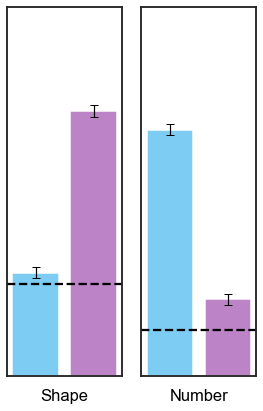

In [62]:


# fig , (ax1,ax2) = plt.subplots(1,2 , figsize = (4,3.75))         # version 2
fig , (ax1,ax2) = plt.subplots(1,2 , sharey=True, figsize = (4,6)) # version 1

ax1.set_ylim(0,1)
ax2.set_ylim(0,1)

# fig.suptitle("Human", fontsize=24)                                 # version 1

shape_acc = condition_acc[condition_acc['rate_condition'] == 'shape']
ax1.bar(shape_acc['orig_game_condition'],
        height=shape_acc['mean'],
        color = ['#7DCCF4','#BD83C7'], alpha=1,
        yerr= shape_acc['ci95_hi']-shape_acc['mean'],
        error_kw={'linewidth':1.2,'capsize':4})


# ax1.set_xlabel("Animals",color='#A04EAE')
# ax1.set_xticklabels([])
ax1.set_yticks([])
ax1.set_yticklabels([])
ax1.set_xticks([.5])
ax1.set_xticklabels(["Shape"],color='k')

number_acc = condition_acc[condition_acc['rate_condition'] == 'number']
ax2.bar(number_acc['orig_game_condition'],
        height=number_acc['mean'],
        color = ['#7DCCF4','#BD83C7'], alpha=1,
        yerr= number_acc['ci95_hi']-number_acc['mean'],
        error_kw={'linewidth':1.2,'capsize':4})


# ax2.set_xlabel("Cardinalities",color='#6369AF')
ax2.set_xticks([.5])
ax2.set_xticklabels(["Number"],color='k')

l1=ax1.axhline(0.25,color='black',ls='--')
l1.set_label('l1')

l2=ax2.axhline(0.125,color='black',ls='--')
l2.set_label('l2')

# ax2.set_yticks([0,.25,.5,.75,1])
# ax2.set_yticklabels(['0','.25','.5','.75','1'])
# ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
# ax2.set_ylabel("Accuracy",rotation=270)#,position=(1.5,.5))
ax2.tick_params(axis='y',  labelright='on')

# fig.text(0.5, .02, 'Predicting', ha='center', fontsize=18)


# maybe include individual subjects' performance as well?
# ax1.get_children()[1].set_color((0,0,0,0))
# ax1.get_children()[2].set_color((0,0,0,0))
# ax1.get_children()[1].set_edgecolor('#7DCCF4')
# ax1.get_children()[2].set_edgecolor('#BD83C7')
# ax2.get_children()[1].set_color((0,0,0,0))
# ax2.get_children()[2].set_color((0,0,0,0))
# ax2.get_children()[1].set_edgecolor('#7DCCF4')
# ax2.get_children()[2].set_edgecolor('#BD83C7')

# ax1.scatter(0 + np.random.random(CA_recognizer_acc.size) * .03, CA_recognizer_acc, color='k',s=4,alpha=1) #BD83C7
# ax1.scatter(1 + np.random.random(AA_recognizer_acc.size) * .03, AA_recognizer_acc, color='k',s=4,alpha=1)
# ax2.scatter(0 + np.random.random(CC_recognizer_acc.size) * .03, CC_recognizer_acc, color='k',s=4,alpha=1) #7DCCF4    
# ax2.scatter(1 + np.random.random(AC_recognizer_acc.size) * .03, AC_recognizer_acc, color='k',s=4,alpha=1)

# colors = ['#b53819', '#6a6e9c']
# texts = ["Animal Game Data", "Number Game Data"]
# patches = [ mpatches.Patch(color=colors[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
# ax2.legend(handles=patches, bbox_to_anchor=(1.5, .9), ncol=1 )

# you can't win. Theres no way:
# https://stackoverflow.com/questions/35921626/legend-being-cut-off-on-saving-matplotlib
# https://stackoverflow.com/questions/45239261/matplotlib-savefig-text-chopped-off
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.tight_layout.html
# nothing works



fig.subplots_adjust(left=.2, right=.8,top=.9,bottom=0.2)
plt.tight_layout()
fig.subplots_adjust(bottom=0.1)


fig.savefig('../results/plots/accHuman.pdf')




### Put the measures above over original trial number

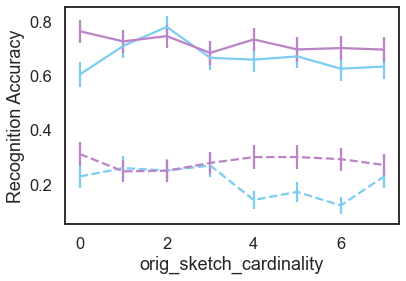

In [16]:

# what should be on x axis? orig_game_trial_num; or orig_sketch_cardinality; or orig_sketch_animal
IV = 'orig_sketch_cardinality'

num_aml_trial_acc = get_confint(pd.DataFrame(D[(D['rate_condition'] == 'number') & (D['orig_game_condition'] == 'shape')].reset_index().groupby([IV])['correct'].agg(['mean', 'count', 'std'])))   
num_num_trial_acc = get_confint(pd.DataFrame(D[(D['rate_condition'] == 'number') & (D['orig_game_condition'] == 'number')].reset_index().groupby([IV])['correct'].agg(['mean', 'count', 'std'])))   
aml_aml_trial_acc = get_confint(pd.DataFrame(D[(D['rate_condition'] == 'shape') & (D['orig_game_condition'] == 'shape')].reset_index().groupby([IV])['correct'].agg(['mean', 'count', 'std'])))   
aml_num_trial_acc = get_confint(pd.DataFrame(D[(D['rate_condition'] == 'shape') & (D['orig_game_condition'] == 'number')].reset_index().groupby([IV])['correct'].agg(['mean', 'count', 'std'])))   

plt.figure()
plt.errorbar(range(len(num_aml_trial_acc)),num_aml_trial_acc['mean'],
             yerr=num_aml_trial_acc['ci95_hi']-num_aml_trial_acc['mean'],
             color='#7DCCF4', linestyle='--') # rate number based on animal sketches
plt.errorbar(range(len(num_num_trial_acc)),num_num_trial_acc['mean'],
             yerr=num_num_trial_acc['ci95_hi']-num_num_trial_acc['mean'],
             color='#7DCCF4')
plt.errorbar(range(len(aml_aml_trial_acc)),aml_aml_trial_acc['mean'],
             yerr=aml_aml_trial_acc['ci95_hi']-aml_aml_trial_acc['mean'],
             color='#BD83C7')
plt.errorbar(range(len(aml_num_trial_acc)),aml_num_trial_acc['mean'],
             yerr=aml_num_trial_acc['ci95_hi']-aml_num_trial_acc['mean'],
             color='#BD83C7',linestyle='--')

plt.xlabel(IV)
plt.ylabel("Recognition Accuracy")

plt.show()



### Recreate the same figures from VGG-19      (acc + confusion matrices)

In [17]:
# Overall, we want to centre the human recognition performance; the VGG is interesting to examine in light of this,
# but the informativeness of the VGG results is dependent on their relation to the actual human performance

numbers = [1,2,3,4,5,6,7,8]
animals = ['bear','deer','owl','rabbit']

def get_conf_mat(df,cond='shape'):
    aml_map = {'bear':0,'deer':1,'owl':2,'rabbit':3}
    num_map = {1:0,2:1,3:2,4:3,5:4,6:5,7:6,8:7}
    if cond == 'number':
        mat = np.zeros((len(num_map.keys()),len(num_map.keys())))
        for row in df.itertuples():
            orig_index = num_map[float(row.orig_sketch_cardinality)]
            recog_index = num_map[float(row.rating)]
            mat[orig_index,recog_index] += 1
    else:
        mat = np.zeros((len(aml_map.keys()),len(aml_map.keys())))
        for row in df.itertuples():
            orig_index = aml_map[row.orig_sketch_animal]
            recog_index = aml_map[row.rating]
            mat[orig_index,recog_index] += 1

    return mat

num_num_conf = get_conf_mat(D[(D['rate_condition'] == 'number') & (D['orig_game_condition'] == 'number')][['rating','orig_sketch_cardinality']], 'number')        
num_aml_conf = get_conf_mat(D[(D['rate_condition'] == 'number') & (D['orig_game_condition'] == 'shape')][['rating','orig_sketch_cardinality']],'number')     
aml_aml_conf = get_conf_mat(D[(D['rate_condition'] == 'shape') & (D['orig_game_condition'] == 'shape')][['rating','orig_sketch_animal']]) 
aml_num_conf = get_conf_mat(D[(D['rate_condition'] == 'shape') & (D['orig_game_condition'] == 'number')][['rating','orig_sketch_animal']])

# get the confmats that we saved out from the CLF
CLF_conf_AA = np.load("datastructures/AA_CLFconfmat.npy") # guessing animal from number game
CLF_conf_AC = np.load("datastructures/AC_CLFconfmat.npy") # guessing number from animal game
CLF_conf_CC = np.load("datastructures/CC_CLFconfmat.npy")
CLF_conf_CA = np.load("datastructures/CA_CLFconfmat.npy")


max_heat_val = np.max([np.max(num_num_conf),
                       np.max(num_aml_conf),
                       np.max(aml_aml_conf),
                       np.max(aml_num_conf)])
min_heat_val = np.min([np.min(num_num_conf),
                       np.min(num_aml_conf),
                       np.min(aml_aml_conf),
                       np.min(aml_num_conf)])

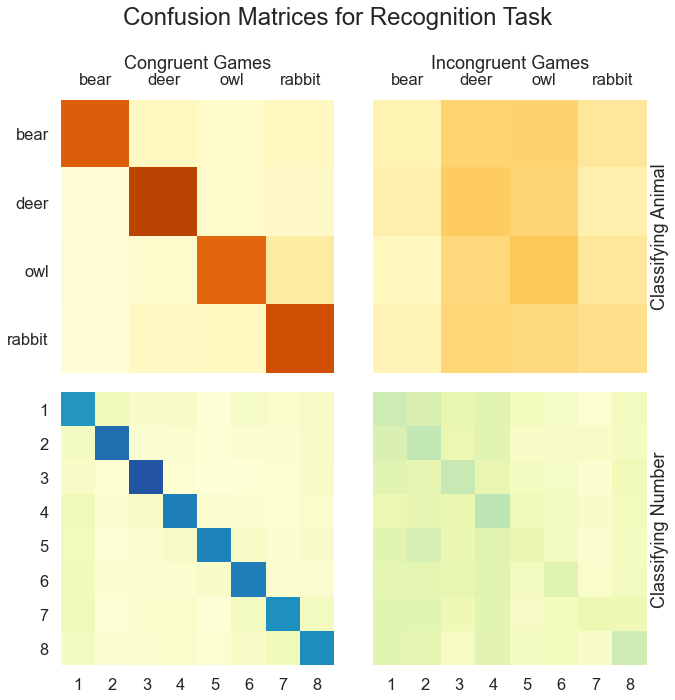

In [18]:
# plot both the CLF and recog task confmats in the same plot
all_confmats = [aml_aml_conf,
                aml_num_conf, # recog number, production animal
                num_num_conf,
                num_aml_conf] # recog animal, production number

## create lookup table of raw confmats (counts, not yet normalized)
clf_list = ['aml_aml_conf','aml_num_conf','num_num_conf','num_aml_conf']
clf_dict = dict(zip(clf_list,all_confmats))

## init normed_confmats with zeros
normed_confmats = dict()
for this_clf in clf_list:
    ## get dims of this confmat
    these_dims = np.shape(clf_dict[this_clf])
    normed_confmats[this_clf] = np.zeros(these_dims)

# normalize all confmats by the sum of the rows (which we controlled to have equal numbers)
for mat_ind, this_matname in enumerate(list(clf_dict.keys())):
    this_mat = clf_dict[this_matname]
    for row_ind, this_row in enumerate(this_mat):
        normed_confmats[this_matname][row_ind,:] = this_row/np.sum(this_row)

conf_fig, ((aml_aml_hm,aml_num_hm),(num_num_hm,num_aml_hm)) = plt.subplots(2,2, figsize=(10,10))

all_axes = [aml_aml_hm,
            aml_num_hm,
            num_num_hm,
            num_aml_hm]

for subp_i in range(len(all_axes)):
    subp = all_axes[subp_i]
    confmat = normed_confmats[clf_list[subp_i]]
    # some lines that will change the heatmap bounds to either be for all plots, or just plots of a given label set:
    cbarval = False if subp_i in [1,3,5,7] else False
    cmapval = 'YlGnBu' if subp_i > 1 else 'YlOrBr'
    ax = sns.heatmap(confmat,cmap=cmapval,cbar=cbarval,ax=subp, vmin=0,vmax=1, square=True)



# now plot everything as four heatmaps, one for each combination of recog and production condition
# conf_fig, ((aml_aml,aml_num), (num_num,num_aml)) = plt.subplots(2,2, figsize=(10,10))
conf_fig.suptitle("Confusion Matrices for Recognition Task",fontsize=24)
# aml_aml_hm = sns.heatmap(aml_aml_conf,cmap='YlOrBr',cbar=False,ax=aml_aml)#, vmin=min_heat_val,vmax=max_heat_val) # recog aml, prod aml
# aml_num_hm = sns.heatmap(aml_num_conf,cmap="YlOrBr",cbar=False,ax=aml_num)#, vmin=min_heat_val,vmax=max_heat_val) # recog aml, prod num

# num_num_hm = sns.heatmap(num_num_conf,cmap="YlGnBu",cbar=False,ax=num_num)#, vmin=min_heat_val,vmax=max_heat_val) # recog num, prod num
# num_aml_hm = sns.heatmap(num_aml_conf,cmap="YlGnBu",cbar=False,ax=num_aml)#, vmin=min_heat_val,vmax=max_heat_val) # recog num, prod aml    cmap='YlGnBu' ?

aml_aml_hm.set_yticklabels(['bear','deer','owl','rabbit'],rotation=0)
aml_aml_hm.set_xticklabels(['bear','deer','owl','rabbit'])
aml_aml_hm.tick_params(labelbottom=False,labeltop=True)
aml_num_hm.set_xticklabels(['bear','deer','owl','rabbit'])
aml_num_hm.tick_params(labelbottom=False,labeltop=True)
aml_num_hm.set_yticklabels([])

num_num_hm.set_yticklabels(['1','2','3','4','5','6','7','8'],rotation=0)
num_num_hm.set_xticklabels(['1','2','3','4','5','6','7','8'])
num_aml_hm.set_xticklabels(['1','2','3','4','5','6','7','8'])
num_aml_hm.set_yticklabels([])

aml_num_hm.set_ylabel("Classifying Animal",rotation=90)
aml_num_hm.yaxis.set_label_position("right")
aml_num_hm.set_xlabel("Incongruent Games")
aml_num_hm.xaxis.set_label_position("top")
aml_aml_hm.set_xlabel("Congruent Games")
aml_aml_hm.xaxis.set_label_position("top")

num_aml_hm.set_ylabel("Classifying Number",rotation=90)
num_aml_hm.yaxis.set_label_position("right")

conf_fig.subplots_adjust(hspace=.1,wspace=.1)

conf_fig.tight_layout()

conf_fig.savefig('../results/plots/humanconfmats.pdf')

# rows (y=axis) are the original sketch label (shape or number), columns (x-axis) are the recog assigned label

In [ ]:
# plot both the CLF and recog task confmats in the same plot
all_confmats = [aml_aml_conf, CLF_conf_AA,
                aml_num_conf, CLF_conf_CA, # recog number, production animal
                num_num_conf, CLF_conf_CC,
                num_aml_conf, CLF_conf_AC] # recog animal, production number

## create lookup table of raw confmats (counts, not yet normalized)
clf_list = ['aml_aml_conf', 'CLF_conf_AA','aml_num_conf', 'CLF_conf_CA',
'num_num_conf', 'CLF_conf_CC','num_aml_conf', 'CLF_conf_AC']
clf_dict = dict(zip(clf_list,all_confmats))

## init normed_confmats with zeros
normed_confmats = dict()
for this_clf in clf_list:
    ## get dims of this confmat
    these_dims = np.shape(clf_dict[this_clf])
    normed_confmats[this_clf] = np.zeros(these_dims)

# normalize all confmats by the sum of the rows (which we controlled to have equal numbers)
for mat_ind, this_matname in enumerate(list(clf_dict.keys())):
    this_mat = clf_dict[this_matname]
    for row_ind, this_row in enumerate(this_mat):
        normed_confmats[this_matname][row_ind,:] = this_row/np.sum(this_row)

conf_fig, ((axRecog1,axCLF1), (axRecog2,axCLF2), (axRecog3,axCLF3), (axRecog4,axCLF4)) = plt.subplots(4,2, figsize=(10,20))

all_axes = [axRecog1, axCLF1,
            axRecog2, axCLF2,
            axRecog3, axCLF3,
            axRecog4, axCLF4]

for subp_i in range(len(all_axes)):
    subp = all_axes[subp_i]
    confmat = normed_confmats[clf_list[subp_i]]
    # some lines that will change the heatmap bounds to either be for all plots, or just plots of a given label set:
    cbarval = False if subp_i in [1,3,5,7] else False
    cmapval = 'YlGnBu' if subp_i > 3 else 'YlOrBr'
    ax = sns.heatmap(confmat,cmap=cmapval,cbar=cbarval,ax=subp, vmin=0,vmax=1, square=True)

axRecog1.set_yticklabels(['bear','deer','owl','rabbit'],rotation=0,fontsize=20)
axRecog1.set_xticklabels(['bear','deer','owl','rabbit'],fontsize=20)
axRecog1.tick_params(labelbottom=False,labeltop=True)
axCLF1.set_xticklabels(['bear','deer','owl','rabbit'],fontsize=20)
axCLF1.tick_params(labelbottom=False,labeltop=True)
axCLF1.set_yticklabels([])
axRecog2.set_yticklabels(['bear','deer','owl','rabbit'],rotation=0,fontsize=20)
axRecog2.set_xticklabels([])
axCLF2.set_yticklabels([])
axCLF2.set_xticklabels([])


axRecog3.set_yticklabels(['1','2','3','4','5','6','7','8'],rotation=0,fontsize=20)
axRecog3.set_xticklabels([])
axCLF3.set_xticklabels([])
axCLF3.set_yticklabels([])

axRecog4.set_yticklabels(['1','2','3','4','5','6','7','8'],rotation=0,fontsize=20)
axRecog4.set_xticklabels(['1','2','3','4','5','6','7','8'],fontsize=20)
axCLF4.set_xticklabels(['1','2','3','4','5','6','7','8'],fontsize=20)
axCLF4.set_yticklabels([])

# setting labels on the top
axRecog1.set_xlabel("Human Confusions",fontsize=24) # 'human' recognition, interpretation, or classification
axRecog1.xaxis.set_label_position("top")
axCLF1.set_xlabel("Model Confusions",fontsize=24) # 'model' recognition, interpretation, or classification
axCLF1.xaxis.set_label_position("top")

# setting labels down the right side
axCLF1.set_ylabel("Animal Games, Animal Ratings",rotation=90)
axCLF1.yaxis.set_label_position("right")
axCLF2.set_ylabel("Number Games, Animal Ratings",rotation=90)
axCLF2.yaxis.set_label_position("right")
axCLF3.set_ylabel("Number Games, Number Ratings",rotation=90)
axCLF3.yaxis.set_label_position("right")
axCLF4.set_ylabel("Animal Games, Number Ratings",rotation=90)
axCLF4.yaxis.set_label_position("right")


conf_fig.tight_layout()
conf_fig.subplots_adjust(hspace=.05,wspace=.05)

conf_fig.savefig('../results/plots/confmats.pdf')

# cb_ax = conf_fig.add_axes([0.83, 0.1, 0.02, 0.8])
# cbar = conf_fig.colorbar(ax, cax=cb_ax)


In [ ]:
# post-hoc num_aml_conf analysis to see heterogeneity in confmat
tosses = np.sum(num_aml_conf , axis = 1) # the number of each cardinality given
guesses = np.sum( num_aml_conf , axis = 0) # this gets the total number of guesses of each label
guesses

In [ ]:
plt.figure()
plt.scatter(np.arange(len(guesses)),guesses)
m, b = np.polyfit(np.arange(len(guesses)), guesses, 1)
plt.plot(np.arange(len(guesses)), m*np.arange(len(guesses)) + b)

In [ ]:
from scipy.stats import chisquare
np.round(chisquare(guesses,f_exp=tosses),3)

In [ ]:
# post-hoc num_aml_conf analysis to see heterogeneity in confmat
tosses = np.sum(aml_num_conf , axis = 1) # the number of each animal given
guesses = np.sum( aml_num_conf , axis = 0) # this gets the total number of guesses of each label
guesses

In [ ]:
plt.figure()
plt.scatter(np.arange(len(guesses)),guesses)
m, b = np.polyfit(np.arange(len(guesses)), guesses, 1)
plt.plot(np.arange(len(guesses)), m*np.arange(len(guesses)) + b)

In [ ]:
np.round(chisquare(guesses,f_exp=tosses),3)

In [ ]:
# look at the effect of cardinality on recog RT
get_confint(D.groupby(['orig_sketch_cardinality'])['RT'].agg(['mean','count','std']))

In [ ]:
stats.spearmanr(all_confmats[0].flatten(),all_confmats[1].flatten())

In [ ]:
stats.spearmanr(all_confmats[4].flatten(),all_confmats[5].flatten())

In [ ]:
np.shape(all_confmats[0].flatten())

In [ ]:



# Methods:
# 1. repeated reference game
    # Procedure
    # Stimuli etc.
    
# 2. recog task
    # # Procedure
    # Stimuli etc.
    
# 3. model-based analyses of the drawings
    # describe CNN structure, training, validation
    

# Results:
# sequence of take-home points
# 1) people are indeed able to differentially communicate number vs shape (acc, RT) without existing symbols
    # create a figure showing accuracy over time
# 2) we notice that stroke number correlates with cardinality when relevant (ink less so), but not otherwise   

# 3) numeral symbols (ones from number game) were TRANSPARENT to strangers (this is a more socially valid measure)
    # ask if recog task number recognition is highest for those number sketches that use the num_strokes correlation with cardinality     
    # stats: 1) overall accuracy relative to chance; 2) accuracy relative to context; 3) does numstrokes number recog acc on num_games?    

# 4) VGG trained on corpus of mostly objects (Imagenet) differential performance on shape vs number.
# How sensitive is it to exact number?      
# "Vision model trained on shape discrimination is good at shape discrimination, but only weakly sensitive to number information"
# comment on the finding that therefore number discrimination isn't a very natural extension of other visual features
# category discriminating pre-training objective seems to reach a limit at numerosity! What other mechanisms do we need?    
# to what degree do the VGG representations look like what's thought to go on in humans when they work with number
# Look at human confusion matrices. Look at VGG confusion matrices. Are they similar?
# They might be more similar for shape than for number

# look at Spearman correlation between conf_mats (turned into 1-D vectors) of humans and VGG
# put it onto a scatterplot. That correlation might be alright for shape, probably won't for number






# 5) Qualitative, impressionistic: the kinds of strategies that people seem to be using (?)
# classifiers, 





In [ ]:
# groupy factor: iterationName, rate_condition, orig_game_condition, workerID
all_acc = get_confint(pd.DataFrame(D.groupby(['rate_condition'])['correct'].agg(['mean', 'count', 'std']))).reset_index()        
all_acc


In [ ]:
recognizer_acc = pd.DataFrame(D.groupby(['rate_condition','orig_game_condition','workerID'])['correct'].mean()).reset_index()    


In [ ]:
get_confint(D.groupby(['orig_game_condition','rate_condition'])['correct'].agg(['mean','count','std']))